In [8]:
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras import backend as Kbe
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image as IMG

In [10]:
#Using the VGG16 model 
model = VGG16(weights = 'imagenet')

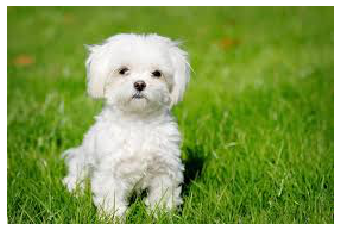

In [12]:
img_path = 'img/dog_img.jpg'
img = mpimg.imread(img_path)
plt.axis('off')
plt.imshow(img)

In [23]:
def process_img(input_img):
    load_img = IMG.load_img(input_img, target_size=(224, 224))
    np_array = IMG.img_to_array(load_img)
    np_array = np.expand_dims(np_array, axis=0)
    np_array = preprocess_input(np_array)
    return np_array
    

In [24]:
processed_img = process_img(img_path)

In [25]:
def pedict(proc_img):
    predict = model.predict(proc_img)
    predictions = pd.DataFrame(decode_predictions(predict, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    print('PREDICTION:',predictions.loc[0,'category'])
    f = sns.barplot(x='probability',y='category',data=predictions,color="purple")
    sns.set_style(style='white')
    f.grid(True)
    f.spines["top"].set_visible(True)
    f.spines["right"].set_visible(True)
    f.spines["bottom"].set_visible(True)
    f.spines["left"].set_visible(True)
    f.set_title('Top 3 Predictions:')
    
    return predictions

PREDICTION: Maltese_dog


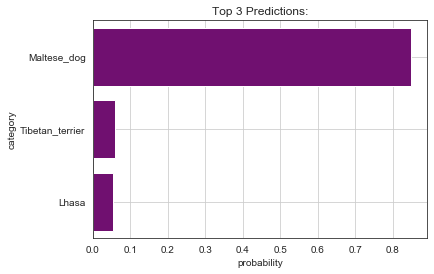

In [26]:
pedections = pedict(processed_img)

In [31]:
def generate_heatmap(predicted):
    np_argmax = np.argmax(predict[0])

    output = model.output[:, np_argmax]

    conv_layer = model.get_layer('block5_conv3')

    gradient = Kbe.gradients(output, conv_layer.output)[0]

    pooled_grad = Kbe.mean(gradient, axis=(0, 1, 2))
    
    iterate = Kbe.function([model.input], [pooled_grad, conv_layer.output[0]])
    grad_value, conv_layer_output_value = iterate([processed_img])

    for i in range(512):
        conv_layer_output_value[:, :, i] *= grad_value[i]
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hmap_intens_fac = 0.9
    hmap_img = heatmap * hmap_intens_fac + img

    output = 'img/dog_output2.jpeg'
    cv2.imwrite(output, hmap_img)

    img=mpimg.imread(output)
    
    category = predicted.loc[0,'category']

    print("Done generating headmap for ", category )
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(category)

Done generating headmap for  Maltese_dog


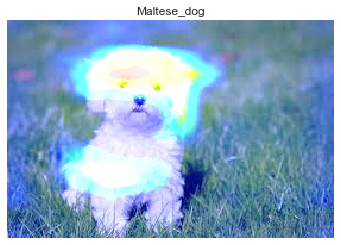

In [32]:
generate_heatmap(predictions)